##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [ ]:
!pip install -q tensorflow_datasets

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1HHWAS/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1HHWAS/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1HHWAS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])
  print(example.shape) ## batch size 64
  ## print(example.numpy()[64]) ## out of bound

texts:  [b'I love Eddie Izzard. I think this is awesome, and the other television specials should be looked at as well. He has a good book "Dress To Kill" out to buy as well, which I think people should read. I loved that this program won an Emmy, and anyone who likes history will probably get a laugh from Eddie. Enjoy :)'
 b"the only word i can think of to describe this movie is: Ordinary.<br /><br />The plot line about Gary sinise's character attempting suicide is a ridiculous premise and c'mon..living as some sort Salingeristic hermit or recluse in a shack driving golf balls into the ocean because he couldn't handle life in the lucrative pro/am golf community? cry me a river. I wish these were my problems. I do enjoy Dylan Baker and Sinise but this movie was clearly a bad choice or a pay check for Sinise. The scene in which little Timmy Price gets verbally abused by the other club member in front of his father during the tournament is so over the top that i am embarrassed to watch i

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:5])
print(vocab.size)

['' '[UNK]' 'the' 'and' 'a']
1000


Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example).numpy()
print(encoded_example.shape)
print(encoded_example[16])
print(example[16]) ## example 16 is the longest, and have length 998. This is why all encoded example has length 998 (paddled with 0)
print(vocab[1], vocab[95], vocab[5], vocab[11]) ## oftenTimes -> [Unknown]
# Oftentimes, films of this
# [UNK] films of this
# 1  95   5  11 -> index in vocab

(64, 1000)
[348  19 206 190   1   1   7   4  53   1   1   6 104  29 262  10  14  41
   1 149  56   1   1 141   2   1   1   3 366 607   9   3 831   6 104   9
  10   1   2 219  62 663   1  17  56   1   1   2 219  62  10  14 352   1
   5 199  42  67   4   1  29  60   1 466   9 127  19  10 153   3 157 142
   1  10   1  13   2 737   7   1  53   1   1   3 455  10   1 434   9  16
   2 473 737  19   2   1   1  64 494   9   7   1   1  16   1  13   4 182
   1   1   8   1   5  25   1   1   8   2  86 171 424   1   1   8   1   3
   7 513   1  33   4   1  36   4 425   5   1   1  40   1   7   1   8 357
  29   7   1  33   2   1 444 131   2  81 357   7   1  13  92   2 343   5
   2  20   7   1 411   6  70   1  10 517  35 138 143   3  65 188   7 370
   1   1 954 270  40   1   5   1   7   2   1 494  11  16   2 343   5   2
  20   1 956   1   5  60   2   1   8  86 213   4   1   1   3 367   9   1
  58  78   4   1   1   3  92 279   1   1   6 352  49   7 590  42   1  15
  23  77  68  92  10 256  35 160   2   1

In [ ]:
print(example[:3])
print(encoded_example[:3])
print(encoder.get_vocabulary()[52])

tf.Tensor(
[b'I love Eddie Izzard. I think this is awesome, and the other television specials should be looked at as well. He has a good book "Dress To Kill" out to buy as well, which I think people should read. I loved that this program won an Emmy, and anyone who likes history will probably get a laugh from Eddie. Enjoy :)'
 b"the only word i can think of to describe this movie is: Ordinary.<br /><br />The plot line about Gary sinise's character attempting suicide is a ridiculous premise and c'mon..living as some sort Salingeristic hermit or recluse in a shack driving golf balls into the ocean because he couldn't handle life in the lucrative pro/am golf community? cry me a river. I wish these were my problems. I do enjoy Dylan Baker and Sinise but this movie was clearly a bad choice or a pay check for Sinise. The scene in which little Timmy Price gets verbally abused by the other club member in front of his father during the tournament is so over the top that i am embarrassed to watc

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  ##print(vocab[encoded_example[n]])
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I love Eddie Izzard. I think this is awesome, and the other television specials should be looked at as well. He has a good book "Dress To Kill" out to buy as well, which I think people should read. I loved that this program won an Emmy, and anyone who likes history will probably get a laugh from Eddie. Enjoy :)'
Round-trip:  i love [UNK] [UNK] i think this is [UNK] and the other television [UNK] should be looked at as well he has a good book [UNK] to kill out to buy as well which i think people should read i loved that this [UNK] [UNK] an [UNK] and anyone who [UNK] history will probably get a laugh from [UNK] enjoy                                                                                                                                                                                                                                                                                                                                                                             

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), ## output is 64*2 vector to represent this sequence
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding. 

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
print(predictions)

[-0.00853689]
[[-0.00853689]]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding, ## With a long sentence of 2000 length, this won't affect the short senctence, so the result for the short sentence is the same.

##padding = "the " * 2000 + "there" * 10
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding])) ## the padding part is not important, it won't affect the result
print(predictions[0])
print(predictions)

[-0.00853689]
[[-0.00853689]
 [ 0.00779328]]


In [ ]:
np.array([sample_text, padding])

array(['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.',
       'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 39s 83ms/step - loss: 0.6819 - accuracy: 0.5184 - val_loss: 0.6020 - val_accuracy: 0.5417
Epoch 2/10
391/391 [==============================] - 30s 77ms/step - loss: 0.5480 - accuracy: 0.6964 - val_loss: 0.4137 - val_accuracy: 0.8115
Epoch 3/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3988 - accuracy: 0.8213 - val_loss: 0.3775 - val_accuracy: 0.8224
Epoch 4/10
391/391 [==============================] - 31s 77ms/step - loss: 0.3558 - accuracy: 0.8448 - val_loss: 0.3588 - val_accuracy: 0.8359
Epoch 5/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3329 - accuracy: 0.8551 - val_loss: 0.3500 - val_accuracy: 0.8292
Epoch 6/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3174 - accuracy: 0.8614 - val_loss: 0.3312 - val_accuracy: 0.8469
Epoch 7/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3089 - accuracy: 0.8667 - val_loss: 0.3293 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 15s 39ms/step - loss: 0.3184 - accuracy: 0.8510
Test Loss: 0.3184363543987274
Test Accuracy: 0.8510000109672546


(0.0, 0.6730962783098221)

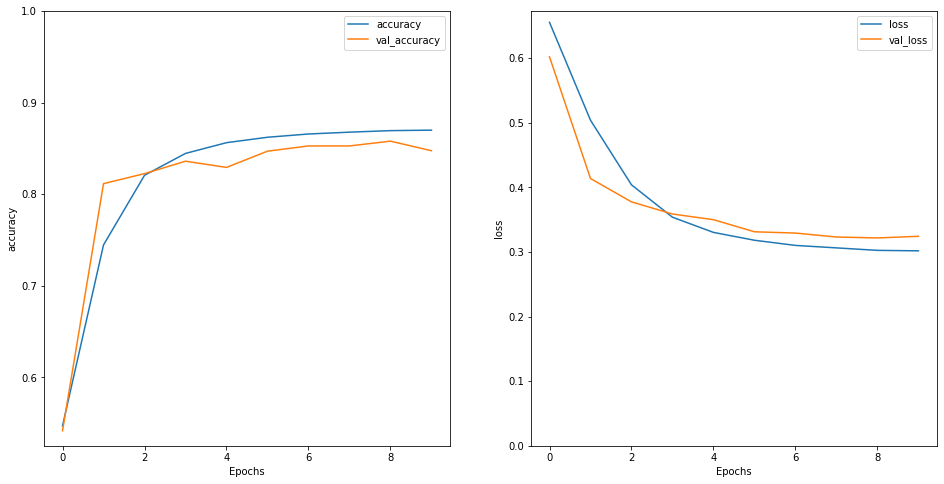

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/layered_bidirectional.ipynb?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=3)

391/391 [==============================] - 75s 151ms/step - loss: 0.6776 - accuracy: 0.5162 - val_loss: 0.4783 - val_accuracy: 0.8073


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 28s 73ms/step - loss: 0.3270 - accuracy: 0.8620
Test Loss: 0.32701966166496277
Test Accuracy: 0.8620399832725525


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8894802]]


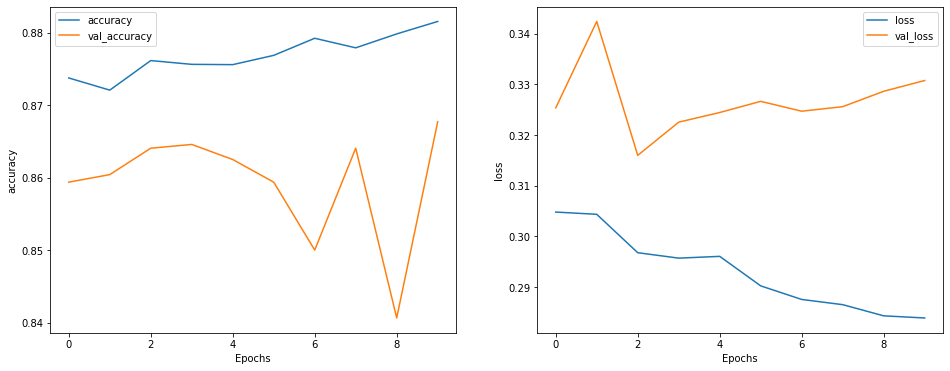

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
